In [1]:
from keras.models import Model, Sequential
from keras import layers
import numpy as np
from keras.applications import InceptionV3,InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras import backend as K

import pickle
import h5py

Using TensorFlow backend.


In [2]:
word_embeddings = h5py.File('processed_data/meme_embeddings.hdf5')['meme_embeddings'][:]
with open('processed_data/meme_vocabulary.p', 'rb') as f:
    vocabulary = pickle.load(f)

assert(len(word_embeddings) == len(vocabulary)+1)
VOCAB_SIZE = len(vocabulary)+1

with open('processed_data/inference_meme_embeddings.p', 'rb') as f:
    img_label_embeddings = pickle.load(f)

inv_map = {v: k for k, v in vocabulary.items()}

In [3]:
# Image embedding
img_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(216,216,3), pooling='avg')


In [4]:
# Meme label embedding
def embedding_avg(x):
    return K.mean(x, axis=1)

labels_input = layers.Input(shape=(None,))
glove_embedding = layers.Embedding(VOCAB_SIZE, 300, weights=[word_embeddings], mask_zero=True, input_length=25)
label_embedding = glove_embedding(labels_input)
label_avg_embedding = layers.Lambda(embedding_avg)(label_embedding)

In [5]:
# Embedding model

concat = layers.Concatenate()([img_model.output, label_avg_embedding])
embedding = layers.Dense(300)(concat)
rshp = layers.Reshape((1,300))(embedding)
lstm_layer = layers.LSTM(512, return_sequences=True, return_state=True)
_, lstm_initial_state1, lstm_initial_state2 = lstm_layer(rshp)


seq_input = layers.Input(shape=(None,))
x = glove_embedding(seq_input)
x, _, _ = lstm_layer(x, initial_state=[lstm_initial_state1, lstm_initial_state2])
x = layers.TimeDistributed(layers.Dense(VOCAB_SIZE, activation='softmax'))(x)

embedding_model = Model(inputs=[img_model.input, labels_input, seq_input], outputs=x)

embedding_model.compile('adam', 'categorical_crossentropy')


In [6]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 216, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 107, 107, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 107, 107, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 107, 107, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
X = h5py.File('processed_data/X.hdf5')
X1 = X['X_img']
X2 = X['X_label']
X3 = X['X_caption']
y = h5py.File('processed_data/y.hdf5')['y']

In [8]:
X1, X2, X3, y

(<HDF5 dataset "X_img": shape (343, 216, 216, 3), type "<f4">,
 <HDF5 dataset "X_label": shape (343, 25), type "<i4">,
 <HDF5 dataset "X_caption": shape (343, 25), type "<i4">,
 <HDF5 dataset "y": shape (343, 25, 610), type "|b1">)

In [102]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=32, epochs=10, shuffle='batch')

Epoch 1/10
343/343 [==============================] - 53s 154ms/step - loss: 0.5185
Epoch 2/10
343/343 [==============================] - 54s 156ms/step - loss: 0.5081
Epoch 3/10
343/343 [==============================] - 53s 154ms/step - loss: 0.5064
Epoch 4/10
 64/343 [====>.........................] - ETA: 45s - loss: 0.5279

KeyboardInterrupt: 

# Inference

In [103]:
from PIL import Image
from pathlib import Path
import os

In [109]:
from keras.preprocessing.sequence import pad_sequences

def generate_captions(model, image_embedding, label_embedding, beam_size=5):
    start = [vocabulary['<start>']]
    captions = [[start,0.0]]
    step = 0
    temp = 1.3
    while(len(captions[0][0]) < 25):
        temp_captions = []
        for caption in captions:
            partial_caption = pad_sequences([caption[0]], maxlen=25, padding='post')
            next_words_pred = model.predict([image_embedding, label_embedding, np.asarray(partial_caption)])[0,step]
            next_words = np.argsort(next_words_pred)[-beam_size:]
            candidate_next_words = next_words_pred[next_words]
            candidate_next_words = (candidate_next_words**(1/temp))/(candidate_next_words**(1/temp)).sum()
            word = np.random.choice(next_words, p=candidate_next_words)
            new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
            new_partial_caption.append(word)
#             new_partial_caption_prob += next_words_pred[word]
            temp_captions.append([new_partial_caption,new_partial_caption_prob])
        captions = temp_captions
#         captions.sort(key = lambda l:l[1])
#         captions = captions[-beam_size:]
        step +=1
    return captions

def sentences(caption_idxes):
    words = []
    for idx in caption_idxes[0]:
        if idx != 0:
            word = inv_map[idx]
            if word == '<start>':
                continue
            if word == '<end>':
                break
            else:
                words.append(word)
    print(' '.join(words))

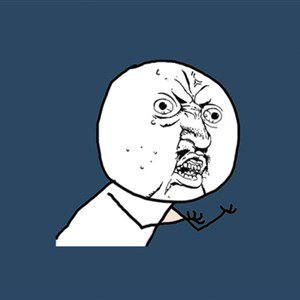

memegenerator users y u so <unk> ?
alarm clock <sep> y u no <unk> ?
alarm commercials <sep> nobody y never come never
skyrim exam y u so a all <sep> <unk> and no funny ?
<unk> free internet <sep> y u no give old layout !?
alarm clock <sep> y u no just <unk>
<unk> exam <sep> why you no all .
<unk> <sep> y u wifi so slow ?
alarm clock <sep> y u no just <unk>
skyrim guards <sep> y u no <unk> of the rest ?!


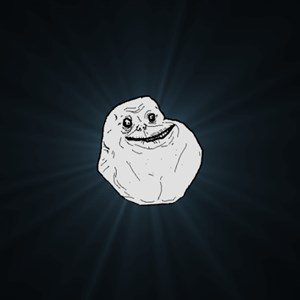

a girl is <unk> <sep> nobody me me
phone <unk> doesn't come in class <sep>
girl posts on her wall <sep> virus
<unk> . google . com <sep> speak speak
i had a threesome , <sep> i love only my only a clock
<unk> at forever alone memes <sep> by by myself
<unk> . . . my only pal pal <sep> my only friend
girl posts hands on wall <sep> virus
gets funny message from <sep> <unk>
i'm forever forever alone ? <sep> i'm forever party


In [110]:
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:2]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])